In [1]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import joblib

#This file contains the commonly used functions
import utility_functions as uf
from collections import Counter

#WOE Binning
import WOE_IV as woe

In [3]:
#ML Algorithms
from sklearn.linear_model import LogisticRegression as LoR

#Evaluation Metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
os.getcwd()

'/home/shrikrishna/Documents/Janta Hack'

In [7]:
#Load the data files
train_data, test_data = list(map(pd.read_csv,\
                                 ['train_20D8GL3.csv', 'test_O6kKpvt.csv']))

In [8]:
print("Train Shape:- {}" .format(train_data.shape))
print("Test Shape: {}" .format(test_data.shape))

Train Shape:- (21000, 25)
Test Shape: (9000, 24)


In [9]:
train_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,25150,360000,2,2,2,25,-1,-1,-1,-1,...,3435,8870,2020,12590,3479,3446,8870,2020,27043,0
1,13470,240000,2,1,2,46,2,2,-2,-1,...,2240,1681,2267,0,0,2240,0,2267,3074,0
2,3092,320000,2,2,1,41,0,0,0,0,...,35409,35036,35939,5000,2000,2000,3000,3000,1500,0
3,13973,50000,2,2,2,24,-1,-1,-2,-2,...,0,0,0,0,0,0,0,0,0,1
4,10567,80000,1,3,1,52,-1,0,0,0,...,20561,21261,21457,1500,1500,1500,1028,876,1449,0


In [10]:
target = 'default_payment_next_month'
target

'default_payment_next_month'


## Missing Value Stats

In [11]:
help(uf.find_missing)

Help on function find_missing in module utility_functions:

find_missing(data)
    #Missing Value Analysis



In [12]:
missing_data_stats = uf.find_missing(train_data)
missing_data_stats.head()


,Missing Count,Missing Percentage
Features,,
ID,0,0.0
BILL_AMT2,0,0.0
PAY_AMT6,0,0.0
PAY_AMT5,0,0.0
PAY_AMT4,0,0.0


## Categorical Variables

In [13]:
#Unique categories of a categorical variable
print('Unique Values:')
for var in ['SEX', 'MARRIAGE', 'EDUCATION']:
    
    print(var + ":\t" + str(np.unique(train_data[var])))

Unique Values:
SEX:	[1 2]
MARRIAGE:	[0 1 2 3]
EDUCATION:	[0 1 2 3 4 5 6]


In [14]:
#Convert the categorical columns represented in number format
#to original level

'''
EDUCATION ----> (1=graduate school, 2=university,
                 3=high school, 4=others, 5=unknown, 6=unknown)
'''
sex_map = {1: 'Male', 2: 'Female'}
marriage_map = {0: 'Unknown', 1: 'Married', 2: 'Single', 3: 'Divorced'}
education_map = {0: 'Unknown', 1: 'graduate_school', 2: 'university',\
                3: 'high_school', 4: 'others', 5: 'UNK_1',\
                6: 'UNK_2'}
target_map = {1: 'Yes', 0: 'No'}

In [15]:
def mapping_levels(data):
    data['SEX_decoded'] = data['SEX'].map(sex_map)
    data['MARRIAGE_decoded'] = data['MARRIAGE'].map(marriage_map)
    data['EDUCATION_decoded'] = data['EDUCATION'].map(education_map)

In [16]:
#Apply the mapping on both the training and test data
list(map(mapping_levels, [train_data, test_data]))

[None, None]

In [17]:
train_data[['SEX_decoded', 'MARRIAGE_decoded', 'EDUCATION_decoded']].head()

,SEX_decoded,MARRIAGE_decoded,EDUCATION_decoded
0,Female,Single,university
1,Female,Single,graduate_school
2,Female,Married,university
3,Female,Single,university
4,Male,Married,high_school


In [18]:
test_data[['SEX_decoded', 'MARRIAGE_decoded', 'EDUCATION_decoded']].head()

,SEX_decoded,MARRIAGE_decoded,EDUCATION_decoded
0,Female,Married,university
1,Female,Single,graduate_school
2,Male,Single,graduate_school
3,Male,Single,graduate_school
4,Male,Single,university


In [19]:
#Create a data frame of data types
#The data types are already stores in variables above

def create_data_type_df(data = train_data):
    data_type_df = pd.DataFrame()
    
    #Columns
    variables = data.columns.tolist()
    data_types = []
    
    for var in variables:
        if(var in integer_cols):
            data_types.append('Integer')
        elif(var in categorical_cols):
            data_types.append('Categorical')
        elif(var in float_cols):
            data_types.append('FLoat')
        else:
            data_types.append('Other')
    
    #Fill the data frame
    data_type_df['Variables'] = variables 
    data_type_df['Data Types'] = data_types

    return data_type_df

## Rename the Bills and Payment columns Month-wise

BILL_AMT2 ---> BILL for August Month

PAY_AMT1 ----> August's Payment in September


In [20]:
#April's Bill Amount and Payment Amount
train_data[['PAY_AMT5', 'BILL_AMT6']].head()

,PAY_AMT5,BILL_AMT6
0,2020,2020
1,2267,2267
2,3000,35939
3,0,0
4,876,21457


In [21]:
#Create a list of n_th payment and (n+1)_th Bill
pay_bill_list = []
for i in range(1, 6):
    if(i==1):
        pay_bill_list += ['BILL_AMT' + str(i+1), 'PAY_AMT' + str(i), \
                     'PAY_' + str(i-1)]
        continue
    pay_bill_list += ['BILL_AMT' + str(i+1), 'PAY_AMT' + str(i), \
                     'PAY_' + str(i)]
    
pay_bill_list

['BILL_AMT2',
 'PAY_AMT1',
 'PAY_0',
 'BILL_AMT3',
 'PAY_AMT2',
 'PAY_2',
 'BILL_AMT4',
 'PAY_AMT3',
 'PAY_3',
 'BILL_AMT5',
 'PAY_AMT4',
 'PAY_4',
 'BILL_AMT6',
 'PAY_AMT5',
 'PAY_5']

In [22]:
#BILL_AMT1 ---> Bill Amount for the month of September
train_data[['BILL_AMT1'] + pay_bill_list + ['PAY_AMT6']].head()

,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_0,BILL_AMT3,PAY_AMT2,PAY_2,BILL_AMT4,PAY_AMT3,PAY_3,BILL_AMT5,PAY_AMT4,PAY_4,BILL_AMT6,PAY_AMT5,PAY_5,PAY_AMT6
0,20952,12590,12590,-1,3479,3479,-1,3435,3446,-1,8870,8870,-1,2020,2020,-1,27043
1,456,0,0,2,0,0,2,2240,2240,-2,1681,0,-1,2267,2267,0,3074
2,49846,53811,5000,0,38717,2000,0,35409,2000,0,35036,3000,0,35939,3000,0,1500
3,2675,0,0,-1,0,0,-1,0,0,-2,0,0,-2,0,0,-2,0
4,35861,18521,1500,-1,19385,1500,0,20561,1500,0,21261,1028,0,21457,876,0,1449


In [23]:
train_data[['BILL_AMT1'] + pay_bill_list + ['PAY_AMT6']].tail()

,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_0,BILL_AMT3,PAY_AMT2,PAY_2,BILL_AMT4,PAY_AMT3,PAY_3,BILL_AMT5,PAY_AMT4,PAY_4,BILL_AMT6,PAY_AMT5,PAY_5,PAY_AMT6
20995,0,0,0,1,0,0,-2,0,0,-2,0,0,-2,0,0,-2,0
20996,69767,73197,5000,0,44195,3000,0,45458,2000,0,48679,4000,0,49895,2000,0,2000
20997,21509,20877,0,1,24122,3600,2,23440,0,2,28843,6000,2,31353,3000,0,0
20998,28477,28718,2000,0,28847,2000,0,28747,2000,0,29177,2000,0,29452,2000,0,2000
20999,0,0,0,1,0,0,-2,0,0,-2,0,0,-2,0,0,-2,0


In [24]:
#Find the total bill amount and the total Payment amount
pay_amt_cols = [col for col in \
                ['BILL_AMT1'] + pay_bill_list + ['PAY_AMT6']\
               if('PAY_AMT' in col)]
bill_amt_cols = [col for col in \
                ['BILL_AMT1'] + pay_bill_list + ['PAY_AMT6']\
               if('BILL_AMT' in col)]



In [25]:
train_data[pay_amt_cols].head()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,12590,3479,3446,8870,2020,27043
1,0,0,2240,0,2267,3074
2,5000,2000,2000,3000,3000,1500
3,0,0,0,0,0,0
4,1500,1500,1500,1028,876,1449


In [26]:
def get_total_amount(data):
    pay_amt = np.array(data[pay_amt_cols])
    bill_amt = np.array(data[bill_amt_cols])

    total_bill_amt, total_pay_amt = [], []

    #Iterate over the rows and get the sum
    total_pay_amt = [sum(amts) for amts in pay_amt]
    total_bill_amt = [sum(amts) for amts in bill_amt]
    
    return (total_pay_amt, total_bill_amt)

In [27]:
#Append the total_pay_amt and total_bill_amt
'''
train_data
'''
total_pay_amt_train, total_bill_amt_train = get_total_amount(train_data)
train_data['Total_Bill_Amount'] = total_bill_amt_train
train_data['Total_Pay_Amount'] = total_pay_amt_train

'''
test_data
'''
total_pay_amt_test, total_bill_amt_test = get_total_amount(test_data)
test_data['Total_Bill_Amount'] = total_bill_amt_test
test_data['Total_Pay_Amount'] = total_pay_amt_test

In [28]:
train_data[bill_amt_cols + ['Total_Bill_Amount']].head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,Total_Bill_Amount
0,20952,12590,3479,3435,8870,2020,51346
1,456,0,0,2240,1681,2267,6644
2,49846,53811,38717,35409,35036,35939,248758
3,2675,0,0,0,0,0,2675
4,35861,18521,19385,20561,21261,21457,137046


In [29]:
##Desciption of Repayment Status
repayment_status = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
train_data[repayment_status].head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,-1,-1,-1,-1,-1,-1
1,2,2,-2,-1,0,-1
2,0,0,0,0,0,0
3,-1,-1,-2,-2,-2,-2
4,-1,0,0,0,0,0


In [30]:
train_data[repayment_status].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,21000.00000,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000
mean,-0.01119,-0.127238,-0.164857,-0.21819,-0.260952,-0.288667
std,1.12321,1.198957,1.198624,1.17221,1.141454,1.151592
min,-2.00000,-2.000000,-2.000000,-2.00000,-2.000000,-2.000000
25%,-1.00000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
50%,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
max,8.00000,8.000000,8.000000,8.00000,8.000000,8.000000


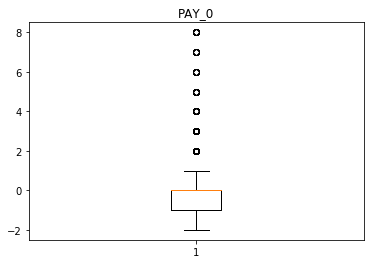

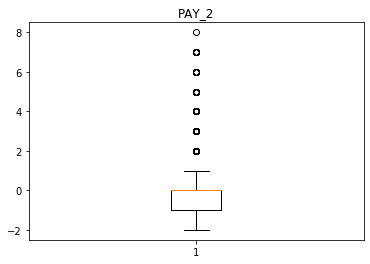

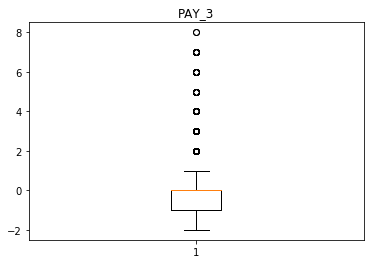

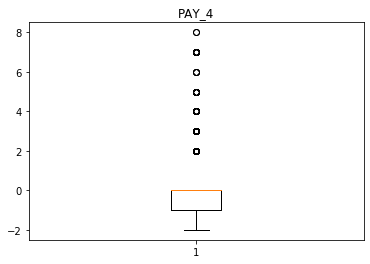

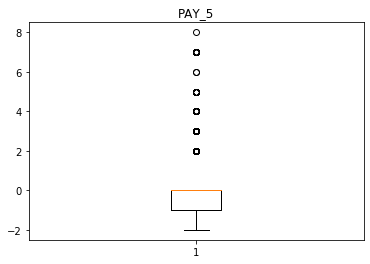

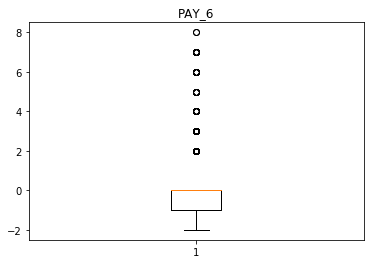

In [31]:
#Mean < Median ===> Left Skewed(Negatively Skewed)
for var in repayment_status:
    
    plt.boxplot(train_data[var])
    plt.title(var)
    plt.show()

## Data Types of Variables

In [32]:
help(uf.seggregate_columns_basis_types)

Help on function seggregate_columns_basis_types in module utility_functions:

seggregate_columns_basis_types(data)
    #Seggregate the columns of a data frame based on their data types



In [33]:
integer_cols, float_cols, categorical_cols, other_cols = \
uf.seggregate_columns_basis_types(train_data)

In [34]:
integer_cols

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default_payment_next_month',
 'Total_Bill_Amount',
 'Total_Pay_Amount']

In [35]:
len(integer_cols)

27

In [36]:
categorical_cols

['SEX_decoded', 'MARRIAGE_decoded', 'EDUCATION_decoded']

In [37]:
#Write the data_type_df to a file
data_type_df = create_data_type_df()
data_type_df.to_csv('data_types.csv')
data_type_df.head()

,Variables,Data Types
0,ID,Integer
1,LIMIT_BAL,Integer
2,SEX,Integer
3,EDUCATION,Integer
4,MARRIAGE,Integer


## Bivariate Analysis

In [38]:
#Categorical VS Target
categorical_cols

['SEX_decoded', 'MARRIAGE_decoded', 'EDUCATION_decoded']

In [39]:
for var in categorical_cols:
    df = pd.crosstab(train_data[var], train_data[target])
    print(var)
    print(df)

SEX_decoded
default_payment_next_month      0     1
SEX_decoded                            
Female                      10097  2662
Male                         6258  1983
MARRIAGE_decoded
default_payment_next_month     0     1
MARRIAGE_decoded                      
Divorced                     156    63
Married                     7343  2218
Single                      8822  2362
Unknown                       34     2
EDUCATION_decoded
default_payment_next_month     0     1
EDUCATION_decoded                     
UNK_1                        190    10
UNK_2                         30     4
Unknown                       10     0
graduate_school             5982  1433
high_school                 2618   849
others                        81     4
university                  7444  2345


In [40]:

#This function will divide the set of values into bins
def get_bins(var, data, bins = 10):
    #Numeric Variables
    if(data[var].dtype == int or data[var].dtype == float):
        bins = pd.cut(data[var], bins=bins) #no. of bins can be changed
        return (bins)
    
    #If the variable is categorical each category acts like a bin
    if(data[var].dtype == object):
        categories = list(np.unique(data[var]))
        return (categories)
    return None

#Avoiding
'''
Log(0/1)
Log(1/0)
'''
def woe_iv_sanity(goods, bads, total_goods, total_bads):
    if(goods == 0):
        goods = ((goods + 0.5)/total_goods)
    if(bads == 0):
        bads = ((bads + 0.5)/total_bads)
    
    return (goods, bads)

def get_group_wise_stats(data, total_defaulters, total_non_defaulters, target = 'default_payment_next_month'):
    #Frequency, %goods, %bads
    frequency = data.shape[0]
    no_goods = data.loc[data[target]==1, 'default_payment_next_month'].shape[0]
    no_bads = frequency - no_goods
    
    #Handling the 0 values
    no_goods, no_bads = woe_iv_sanity(no_goods, no_bads, total_defaulters, total_non_defaulters)
    
    per_goods, per_bads = list(map(lambda x: x*100/frequency,\
                                   [no_goods, no_bads]))
    
    return (frequency, per_goods, per_bads)

def WOE_IV(var, data, target='default_payment_next_month'):
    #Number of defaulters and non-defaulters
    total_defaulters = data.loc[data[target]==1, target].shape[0]
    total_non_defaulters = data.shape[0] - total_defaulters
    
    #Obtain the bins
    bins = get_bins(var, data)
    
    #Create a WOE_IV data frame
    WOE_IV_df = pd.DataFrame()
    bins, woe_s, iv_s = [], [], []
    
    if(data[var].dtype == object):
        bin_grp = data.groupby(var)
        for grp, df in bin_grp:
            #Calculate the number of goods and bads
            frequency, per_defaulters, per_non_defaulters = get_group_wise_stats(df, total_defaulters, total_non_defaulters)
            
			#woe = log(#Events/#Non-Events)
            woe_s.append(np.log(per_defaulters/per_non_defaulters))
            iv_s.append(per_defaulters - per_non_defaulters)
        
        WOE_IV_df[var + '_bins'] = list(bin_grp.groups)
        WOE_IV_df['WOE'] = woe_s
        WOE_IV_df['IV'] = iv_s
    return WOE_IV_df

In [41]:
Counter(train_data['MARRIAGE_decoded'])

Counter({'Single': 11184, 'Married': 9561, 'Divorced': 219, 'Unknown': 36})

In [42]:
#WOE values
for var in categorical_cols:
    try:
        print(var)
        WOE_IV_df = WOE_IV(var, train_data)
        
        #Sort the df in ascending order of their WOE values
        WOE_IV_df = WOE_IV_df.sort_values(by = 'WOE')
        print(WOE_IV_df)
    except TypeError as e:
        
        print("Problem in " + var)
        print("Error:- " + e)

SEX_decoded
  SEX_decoded_bins       WOE         IV
0           Female -1.333161 -58.272592
1             Male -1.149250 -51.874772
MARRIAGE_decoded
  MARRIAGE_decoded_bins       WOE         IV
3               Unknown -2.833213 -88.888889
2                Single -1.317740 -57.761087
1               Married -1.197142 -53.603180
0              Divorced -0.906721 -42.465753
EDUCATION_decoded
  EDUCATION_decoded_bins        WOE         IV
2                Unknown -11.439279 -99.998924
5                 others  -3.008155 -90.588235
0                  UNK_1  -2.944439 -90.000000
1                  UNK_2  -2.014903 -76.470588
3        graduate_school  -1.428985 -61.348618
6             university  -1.155123 -52.089080
4            high_school  -1.126107 -51.023940


In [43]:
#Combine the levels having similar WOE values
'''
Combining university and high_school in EDUCATION_decoded
into a new category 'uni_high'
'''
train_data.loc[(train_data['EDUCATION_decoded']=='university') |\
              (train_data['EDUCATION_decoded']=='high_school'),\
              'EDUCATION_decoded'] = 'uni_high'


#Perform the same changes on the test data
train_data.loc[(train_data['EDUCATION_decoded']=='university') |\
              (train_data['EDUCATION_decoded']=='high_school'),\
              'EDUCATION_decoded'] = 'uni_high'

In [44]:
#After grouping
#WOE values
for var in categorical_cols:
    try:
        print(var)
        WOE_IV_df = WOE_IV(var, train_data)
        
        #Sort the df in ascending order of their WOE values
        WOE_IV_df = WOE_IV_df.sort_values(by = 'WOE')
        print(WOE_IV_df)
    except TypeError as e:
        
        print("Problem in " + var)
        print("Error:- " + e)

SEX_decoded
  SEX_decoded_bins       WOE         IV
0           Female -1.333161 -58.272592
1             Male -1.149250 -51.874772
MARRIAGE_decoded
  MARRIAGE_decoded_bins       WOE         IV
3               Unknown -2.833213 -88.888889
2                Single -1.317740 -57.761087
1               Married -1.197142 -53.603180
0              Divorced -0.906721 -42.465753
EDUCATION_decoded
  EDUCATION_decoded_bins        WOE         IV
2                Unknown -11.439279 -99.998924
4                 others  -3.008155 -90.588235
0                  UNK_1  -2.944439 -90.000000
1                  UNK_2  -2.014903 -76.470588
3        graduate_school  -1.428985 -61.348618
5               uni_high  -1.147492 -51.810501


In [45]:
test_data.shape

(9000, 29)

In [46]:
train_data.shape

(21000, 30)

In [47]:
integer_cols[:3]

['ID', 'LIMIT_BAL', 'SEX']

## Modelling

In [48]:
#Remove ['SEX', 'EDUCATION', 'MARRIAGE'] from the integer columns
for col in ['SEX', 'EDUCATION', 'MARRIAGE']:
    if(col in integer_cols):
        integer_cols.remove(col)

In [49]:
len(integer_cols)

24

In [50]:
#Consider only integer column
independent_int_cols = list(set(integer_cols).difference(set([target])))
target in independent_int_cols                            

False

In [51]:
#Remove ID
if 'ID' in independent_int_cols:
    independent_int_cols.remove('ID')

### Check the Event Rate

In [57]:
event_rate = train_data[target].sum()/train_data[target].shape[0]
print("Event Rate:- %.2f" %(event_rate))

Event Rate:- 0.22


In [52]:
#Split the train_data into training set and testing set
X = train_data[independent_int_cols]
y = train_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [59]:
print("Train Shape:- {}\t{}" .format(X_train.shape, y_train.shape))
print("Test Shape:- {}\t{}" .format(X_test.shape, y_test.shape))

Train Shape:- (16800, 22)	(16800,)
Test Shape:- (4200, 22)	(4200,)


In [95]:
class Modelling():
    
    def __init__(self, X_train, X_test, y_train, y_test, model, name_of_classifier):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model
        self.clf_name = name_of_classifier
    
    def auc_roc(self, X, y, train_test = 'Test Set'):
        predicted_probability = self.model.predict_proba(X)
        
        #Save the predicted probailities
        probability_df = pd.DataFrame(predicted_probability[::, 1])
        
        fpr, tpr, _ = roc_curve(y,  predicted_probability[::,1])
        auc = roc_auc_score(y, predicted_probability[::,1])
        plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
        plt.legend(loc=4)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(train_test)
        plt.savefig("AUC " + self.clf_name + ".png")
        plt.show()
        
        #Return the probability of predicting 0
        return probability_df
        
    def evaluate(self, CM):
        accuracy = CM.diagonal().sum()/CM.sum()
        precision = CM[0][0]/(CM[0][0] + CM[0][1])
        recall = CM[0][0]/(CM[0][0] + CM[1][0])
        f_measure = (2*precision*recall)/(precision+recall)
        print(CM)
        print("Accuracy:- {:.2f}\nPrecision:- {:.2f}\nRecall:- {:.2f}\nF-measure:- {:.2f}" \
              .format(accuracy,precision, recall, f_measure))
        
    def prediction(self):
        #Fit the model
        model = self.model.fit(self.X_train, self.y_train)
        
        #Predict on train and test set
        predicted_train = model.predict(self.X_train) 
        predicted_test = model.predict(self.X_test)
        
        #Results
        result_test = pd.DataFrame({'Actual':self.y_test.ravel(),\
                                    'Predicted':predicted_test.ravel()},\
                                   columns=['Actual','Predicted'])
        
        #Save the model
        joblib.dump(model, os.getcwd() + "/Models/" + \
                    self.clf_name + ".pkl")
        
        #Print the AUC_ROC curve for train and test data
        train_probability_df = self.auc_roc(self.X_train, \
                                            self.y_train.ravel(), \
                                            'Train Set')
        test_probability_df = self.auc_roc(self.X_test, \
                                           self.y_test.ravel(), \
                                           'Test Set')
        
        #Evaluate the model
        print("Training Data")
        CM_train = confusion_matrix(self.y_train.ravel(), \
                                    predicted_train.ravel(), \
                                    labels=None, sample_weight=None)
        self.evaluate(CM_train)
        
        print("Testing Data")
        CM_test = confusion_matrix(self.y_test.ravel(), \
                                   predicted_test.ravel(), \
                                   labels=None, sample_weight=None)
        self.evaluate(CM_test)
        
        #Return the training probabilities
        return train_probability_df

### Logistic Regression

In [96]:
lr = LoR()
logistic_model = Modelling(X_train, X_test, y_train, y_test,\
                          lr, 'Logistic Regression')

/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


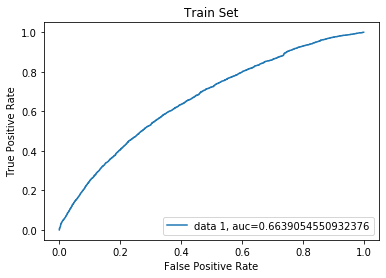

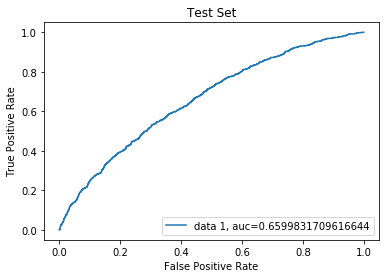

Training Data
[[13117     1]
 [ 3682     0]]
Accuracy:- 0.78
Precision:- 1.00
Recall:- 0.78
F-measure:- 0.88
Testing Data
[[3237    0]
 [ 963    0]]
Accuracy:- 0.77
Precision:- 1.00
Recall:- 0.77
F-measure:- 0.87


In [98]:
#Prediction
train_probabilities = logistic_model.prediction()

In [85]:
train_probabilities.head()

,0
0,0.373567
1,0.247227
2,0.029061
3,0.126101
4,0.286579


In [107]:
#Inheritance
class Tuning(Modelling):
    '''
    Inheriting the class Modelling
    '''
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        #Create a Modelling object
        self.model = Modelling(self.X_train, self.X_test,\
                          self.y_train, self.y_test,\
                          lr, 'Logistic Regression')
        
        #Probabilites of Events(1s)
        self.train_probabilities = self.model.prediction()
    
    #Predictions with certain threshold
    def get_prediction(self, threshold = event_rate):
        '''
        probabilities:- prediction probabilities
        threshold:- threshold value.
                Default set to event_rate.
        '''
        print("Threshold is set to %.2f" %(threshold))
        predictions = list(map(lambda x:1 if(x >= threshold) else 0,\
                               self.train_probabilities[0]))
        
        #Evaluate the predictions
        CM = confusion_matrix(self.y_train.ravel(), \
                              predictions, \
                              labels=None, sample_weight=None)
        
        self.model.evaluate(CM)
    

In [109]:
help(np.linespace)

AttributeError: module 'numpy' has no attribute 'linespace'

/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


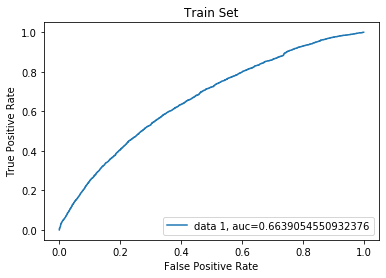

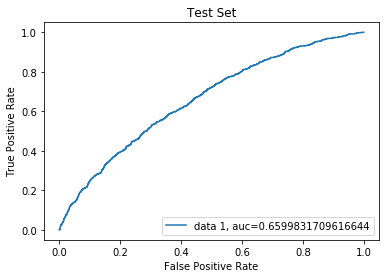

Training Data
[[13117     1]
 [ 3682     0]]
Accuracy:- 0.78
Precision:- 1.00
Recall:- 0.78
F-measure:- 0.88
Testing Data
[[3237    0]
 [ 963    0]]
Accuracy:- 0.77
Precision:- 1.00
Recall:- 0.77
F-measure:- 0.87
Threshold is set to 0.22
[[5790 7328]
 [ 849 2833]]
Accuracy:- 0.51
Precision:- 0.44
Recall:- 0.87
F-measure:- 0.59


In [108]:
tuning = Tuning(X_train, X_test, y_train, y_test)

#Set the threshold
tuning.get_prediction()

In [205]:
#Load the model
model = joblib.load(os.getcwd() + "/Models/Logistic Regression.pkl")

#Obtain the prediction probabilities on original test set
predicted_probability = model.predict_proba(test_data[independent_int_cols])

#Save the predicted probailities
probability_df = pd.DataFrame(predicted_probability[::, 1])

probability_df['ID'] = test_data['ID']
probability_df = probability_df.rename(columns = {0: target})

print(probability_df[['ID', target]].head())
probability_df[['ID', target]].to_csv(os.getcwd() + "/Models/predicted_probabilities.csv")

      ID  default_payment_next_month
0  10178                    0.427110
1   5304                    0.136008
2   5187                    0.183633
3  14495                    0.303057
4  20444                    0.207182


In [193]:
test_data[independent_int_cols].head()

,PAY_2,BILL_AMT1,BILL_AMT5,PAY_6,PAY_0,PAY_3,AGE,BILL_AMT2,Total_Bill_Amount,PAY_AMT5,...,PAY_AMT4,PAY_AMT6,PAY_4,PAY_5,PAY_AMT2,LIMIT_BAL,BILL_AMT6,PAY_AMT1,Total_Pay_Amount,PAY_AMT3
0,0,36082,38667,0,0,0,30,37127,228411,1520,...,1403,1205,0,0,1618,60000,39544,1628,8749,1375
1,0,61099,50292,0,0,0,29,64160,356642,5739,...,0,12050,0,2,14593,200000,10510,4160,56692,20150
2,0,38395,0,-2,0,0,39,39943,98988,0,...,0,0,0,-2,2000,230000,0,2500,4500,0
3,0,152175,142745,0,0,0,40,148872,876433,6500,...,5200,7200,0,0,5245,150000,146872,5800,35145,5200
4,0,80210,78953,0,0,0,27,67746,462941,5000,...,3260,3000,0,0,10000,140000,81848,10000,34653,3393


### Random Forest